In [24]:
# import module libraries
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import optuna

In [25]:
# LSTM with layer normalization
class LayerNormLSTM(nn.Module):
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_x = nn.Linear(input_node, 4*hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4*hidden_node, bias=False)
        self.ln = nn.LayerNorm(4 * hidden_node)
        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, x, hx):
        h, c = hx

        gates = self.w_x(x) + self.w_h(h)
        gates = self.ln(gates)

        i, f, g, o = gates.chunk(4, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_new = f * c + i * g
        c_new = self.ln_c(c_new)
        h_new = o * torch.tanh(c_new)

        return h_new, c_new

In [26]:
# State feature extractor using LayerNorm LSTM
class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for i in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        batch_size, max_len, _ = x.size()
        device = x.device

        h_states = []
        c_states = []

        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))

        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t # initialize layer input with input tensor
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))
                
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)

        output_tensor = torch.stack(outputs, dim=1)
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        return self.dropout(masked_output)

In [27]:
# Physical change regressor
class PhysRegr(nn.Module):
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, output_node))
        layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)

In [28]:
# Current regressor
class CurrRegr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)   

In [29]:
# Physical Constraint Layer
class PhysConstr(nn.Module):
    def __init__(self, range_mm, curr_regr, eps=1e-2):
        super().__init__()
        
        self.eps = eps
        self.curr_regr = curr_regr
        self.register_buffer('range_mm_tensor',self._range2tensor(range_mm))

    def _range2tensor(self, range_mm):
        feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
        ranges = torch.zeros(len(feature_names), 2)

        for i, name in enumerate(feature_names):
            ranges[i, 0] = range_mm[name]['min']
            ranges[i, 1] = range_mm[name]['max']

        return ranges

    def _norm_tensor(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def _denorm_tensor(self, norm_data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return norm_data * (max_val - min_val) + min_val

    def forward(self, phys_chng, cur_state, fin, initV):
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        VF = self._denorm_tensor(cur_state[..., 2:3], VF_idx)
        VA = self._denorm_tensor(cur_state[..., 3:4], VA_idx)
        VB = self._denorm_tensor(cur_state[..., 4:5], VB_idx)
        CFLA = self._denorm_tensor(cur_state[..., 5:6], CFLA_idx)
        CALA = self._denorm_tensor(cur_state[..., 6:7], CALA_idx)
        CFK = self._denorm_tensor(cur_state[..., 7:8], CFK_idx)
        CBK = self._denorm_tensor(cur_state[..., 8:9], CBK_idx)

        ## Flow in parameters
        FvF, FvA, FvB, CFLA_in, CALA_in, CFK_in, CBK_in = fin

        VFi, VAi, VBi = initV

        dVF_in, dVA_in, dVB_in = FvF, FvA, FvB
        dNFLA_in, dNALA_in, dNFK_in, dNBK_in = FvF * CFLA_in, FvA * CALA_in, FvF * CFK_in, FvB * CBK_in

        rdVA = phys_chng[..., 0:1]
        rdVB = phys_chng[..., 1:2]
        rdNALA = phys_chng[..., 2:3]
        rdNBK = phys_chng[..., 3:4]

        ## Mass Balance
        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

### ===== 핵심 변경: Feed 먼저 추가 ===== ###
        # Step 1: Add feed streams
        VF_after_feed = VF + dVF_in
        VA_after_feed = VA + dVA_in
        VB_after_feed = VB + dVB_in
        NFLA_after_feed = NFLA + dNFLA_in
        NALA_after_feed = NALA  # No feed to acid
        NFK_after_feed = NFK + dNFK_in
        NBK_after_feed = NBK    # No feed to base

        # Step 2: Calculate separation based on feed-added state
        dVA = VF_after_feed * (rdVA - 0.5)
        dVB = VF_after_feed * (rdVB - 0.5)
        dNALA = NFLA_after_feed * rdNALA
        dNBK = NFK_after_feed * rdNBK

        ### Step 3: Calculate state after separation (before discharge)
        nVF_bf = VF_after_feed - dVA - dVB
        nVA_bf = VA_after_feed + dVA
        nVB_bf = VB_after_feed + dVB

        nNFLA_bf = NFLA_after_feed - dNALA
        nNALA_bf = NALA_after_feed + dNALA
        nNFK_bf = NFK_after_feed - dNBK
        nNBK_bf = NBK_after_feed + dNBK

        nCFLA = nNFLA_bf / nVF_bf
        nCALA = nNALA_bf / nVA_bf
        nCFK = nNFK_bf / nVF_bf
        nCBK = nNBK_bf / nVB_bf

        dVF_out = nVF_bf - VFi
        dVA_out = nVA_bf - VAi
        dVB_out = nVB_bf - VBi

        nVF = torch.where(dVF_out > 0, nVF_bf - dVF_out, nVF_bf)
        nVA = torch.where(dVA_out > 0, nVA_bf - dVA_out, nVA_bf)
        nVB = torch.where(dVB_out > 0, nVB_bf - dVB_out, nVB_bf)
        
        # dVF_out ~ dVB_out이 0보다 작으면 해당 영역 변수들이 0이 되도록 처리
        dNFLA_out = torch.where(dVF_out > 0, nCFLA * dVF_out, torch.zeros_like(dVF_out))
        dNFK_out = torch.where(dVF_out > 0, nCFK * dVF_out, torch.zeros_like(dVF_out))

        dNALA_out = torch.where(dVA_out > 0, nCALA * dVA_out, torch.zeros_like(dVA_out))
        dNBK_out = torch.where(dVB_out > 0, nCBK * dVB_out, torch.zeros_like(dVB_out))

        ### Final new states
        nNFLA = nNFLA_bf - dNFLA_out
        nNALA = nNALA_bf - dNALA_out
        nNFK = nNFK_bf - dNFK_out
        nNBK = nNBK_bf - dNBK_out

        V = cur_state[..., 0:1]
        E = cur_state[..., 1:2]

        nVF_norm = self._norm_tensor(nVF, VF_idx)
        nVA_norm = self._norm_tensor(nVA, VA_idx)
        nVB_norm = self._norm_tensor(nVB, VB_idx)
        nCFLA_norm = self._norm_tensor(nCFLA, CFLA_idx)
        nCALA_norm = self._norm_tensor(nCALA, CALA_idx)
        nCFK_norm = self._norm_tensor(nCFK, CFK_idx)
        nCBK_norm = self._norm_tensor(nCBK, CBK_idx)

        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)

        nI_pred = self.curr_regr(temp_state)
        nI_real = self._denorm_tensor(nI_pred, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self._norm_tensor(nI_real, I_idx)

        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)

        ### discharge
        discharge = {
            'VF': dVF_out,
            'VA': dVA_out,
            'VB': dVB_out,
            'NFLA': dNFLA_out,
            'NALA': dNALA_out,
            'NFK': dNFK_out,
            'NBK': dNBK_out,
            'CFLA': nCFLA,
            'CALA': nCALA,
            'CFK': nCFK,
            'CBK': nCBK
        }

        discharge_list = [dVF_out[...,0].item(), dVA_out[...,0].item(), dVB_out[...,0].item(), nCFLA[...,0].item(), nCALA[...,0].item(), nCFK[...,0].item(), nCBK[...,0].item()]

        return next_state, discharge, discharge_list

In [30]:
# BMED model
class BMEDModel(nn.Module):
    def __init__(self, state_extr_params, phys_regr_params, curr_regr_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.phys_regr = PhysRegr(**phys_regr_params)
        self.curr_regr = CurrRegr(**curr_regr_params)
        self.phys_constr = PhysConstr(range_mm, self.curr_regr)

    def _init_hidden_states(self, batch_size, device):
        hidden_states = []
        cell_states =[]

        for _ in range(self.state_extr.n_layer):
            hidden_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))
            cell_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))

        return {'hidden': hidden_states, 'cell': cell_states}

    def _input_stage1(self, fresh_feed, stage2_discharge):
        QF_fresh, CFLA_fresh, CFK_fresh = fresh_feed

        if stage2_discharge is not None:
            VA_from_s2 = stage2_discharge[1]
            VB_from_s2 = stage2_discharge[2]
            CALA_from_s2 = stage2_discharge[4]
            CBK_from_s2 = stage2_discharge[6]
        else:
            VA_from_s2 = VB_from_s2 = 0
            CALA_from_s2 = CBK_from_s2 = 0
        
        return [QF_fresh, VA_from_s2, VB_from_s2, CFLA_fresh, CALA_from_s2, CFK_fresh, CBK_from_s2]
    
    def _input_stage2(self, stage1_discharge, fresh_water):
        QA_fresh, QB_fresh = fresh_water

        if stage1_discharge is not None:
            VF_from_s1 = stage1_discharge[0]
            CFLA_from_s1 = stage1_discharge[3]
            CFK_from_s1 = stage1_discharge[5]
        else:
            VF_from_s1 = 0
            CFLA_from_s1 = CFK_from_s1 = 0

        return [VF_from_s1, QA_fresh, QB_fresh, CFLA_from_s1, 0, CFK_from_s1, 0]
    
    def _check_convergence(self, discharge_1, discharge_2, prev_1, prev_2, tolerance):
        if prev_1 is None or prev_2 is None:
            return False
        
        current_1 = torch.tensor([discharge_1['VF'].item(), discharge_1['VA'].item(), discharge_1['VB'].item(), discharge_1['CFLA'].item(), discharge_1['CALA'].item(), discharge_1['CFK'].item(), discharge_1['CBK'].item()])
        current_2 = torch.tensor([discharge_2['VF'].item(), discharge_2['VA'].item(), discharge_2['VB'].item(), discharge_2['CFLA'].item(), discharge_2['CALA'].item(), discharge_2['CFK'].item(), discharge_2['CBK'].item()])

        prev_1_tensor = torch.tensor(prev_1)
        prev_2_tensor = torch.tensor(prev_2)

        # 상대 변화량으로 수정 (0으로 나누기 방지)
        rel_change_1 = torch.abs((current_1 - prev_1_tensor) / (torch.abs(prev_1_tensor) + 1e-8))
        rel_change_2 = torch.abs((current_2 - prev_2_tensor) / (torch.abs(prev_2_tensor) + 1e-8))

        max_change = max(torch.max(rel_change_1), torch.max(rel_change_2))
        return max_change.item() < tolerance

    def _apply_relaxation(self, old_discharge, new_discharge, relaxation_factor):
        if old_discharge is None:
            return [new_discharge['VF'].item(), new_discharge['VA'].item(), new_discharge['VB'].item(), new_discharge['CFLA'].item(), new_discharge['CALA'].item(), new_discharge['CFK'].item(), new_discharge['CBK'].item()]

        new_values = [new_discharge['VF'].item(), new_discharge['VA'].item(), new_discharge['VB'].item(), new_discharge['CFLA'].item(), new_discharge['CALA'].item(), new_discharge['CFK'].item(), new_discharge['CBK'].item()]

        relaxed = []
        for old_val, new_val in zip(old_discharge, new_values):
            relaxed_val = old_val + relaxation_factor * (new_val - old_val)
            relaxed.append(relaxed_val)

        return relaxed


    def cont_sim(self, init_state_1, init_state_2, target_len, fresh_feed, fresh_water, initV, tolerance, max_iter, relaxation):
        batch_size_1 = init_state_1.size(0)
        feature_size_1 = init_state_1.size(1)
        device_1 = init_state_1.device

        batch_size_2 = init_state_2.size(0)
        feature_size_2 = init_state_2.size(1)
        device_2 = init_state_2.device
        
        state1_states = self._init_hidden_states(batch_size_1, device_1)
        state2_states = self._init_hidden_states(batch_size_2, device_2)

        pred1 = torch.zeros(batch_size_1, target_len, feature_size_1, device=device_1)
        pred2 = torch.zeros(batch_size_2, target_len, feature_size_2, device=device_2)

        discharge_record_1 = []
        discharge_record_2 = []
        convergence_info = []

        stage1_discharge_prev= None
        stage2_discharge_prev = None

        cur_state_1 = init_state_1.clone()
        cur_state_2 = init_state_2.clone()

        for t in range(target_len):
            pred1[:, t, :] = cur_state_1
            pred2[:, t, :] = cur_state_2

            if t < target_len - 1:
                lstm_input_1 = cur_state_1[:, :-1] # except current
                lstm_input_2 = cur_state_2[:, :-1] # except current

                hidden_output_1 = self._lstm_single_step(lstm_input_1, state1_states)
                hidden_output_2 = self._lstm_single_step(lstm_input_2, state2_states)

                phys_chng_1 = self.phys_regr(hidden_output_1.unsqueeze(1))
                phys_chng_2 = self.phys_regr(hidden_output_2.unsqueeze(1))
                cur_state_expanded_1 = cur_state_1.unsqueeze(1)
                cur_state_expanded_2 = cur_state_2.unsqueeze(1)

                converged = False
                iteration = 0

                while not converged and iteration < max_iter:
                    fin_1_coupled = self._input_stage1(fresh_feed, stage2_discharge_prev)
                    fin_2_coupled = self._input_stage2(stage1_discharge_prev, fresh_water)

                    next_state_1, discharge_1, _ = self.phys_constr(
                        phys_chng_1, cur_state_expanded_1, fin_1_coupled, initV
                    )
                    
                    next_state_2, discharge_2, _ = self.phys_constr(
                        phys_chng_2, cur_state_expanded_2, fin_2_coupled, initV
                    )
                    
                    # 수렴 체크 추가
                    converged = self._check_convergence(discharge_1, discharge_2, stage1_discharge_prev, stage2_discharge_prev, tolerance)
                    
                    if not converged:
                        stage1_discharge_prev= self._apply_relaxation(stage1_discharge_prev, discharge_1, relaxation)
                        stage2_discharge_prev = self._apply_relaxation(stage2_discharge_prev, discharge_2, relaxation)

                    iteration += 1
                
                convergence_info.append({
                    'time_step': t,
                    'iteration': iteration,
                    'converged': converged
                })

                cur_state_1 = next_state_1.squeeze(1)
                cur_state_2 = next_state_2.squeeze(1)
                discharge_record_1.append(discharge_1)
                discharge_record_2.append(discharge_2)

        return pred1, pred2, discharge_record_1, discharge_record_2, convergence_info

    def _lstm_single_step(self, x_t, stage_states):
        layer_input = x_t
        hidden_states = stage_states['hidden']
        cell_states = stage_states['cell']

        for layer_idx, lstm_cell in enumerate(self.state_extr.lstm_cells):
            h_new, c_new = lstm_cell(layer_input, (hidden_states[layer_idx], cell_states[layer_idx]))
            
            hidden_states[layer_idx] = h_new
            cell_states[layer_idx] = c_new

            if layer_idx < len(self.state_extr.lstm_cells) - 1:
                layer_input = self.state_extr.dropout(h_new)
            else:
                layer_input = h_new # last layer output

        return self.state_extr.dropout(layer_input)

    def forward(self, init_state_1, init_state_2, target_len, fresh_feed, fresh_water, initV, tolerance, max_iter, relaxation):
        return self.cont_sim(init_state_1, init_state_2, target_len, fresh_feed, fresh_water, initV, tolerance, max_iter, relaxation)

In [31]:
# Utility functions

## Normalize input data with the min-max normalization range of pre-trained model
def normalize(inputs, range_mm):
    features = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK']
    norm = []

    for _, (name, value) in enumerate(zip(features, inputs)):
        min_val = range_mm[name]['min']
        max_val = range_mm[name]['max']
        norm_val = (value - min_val) / (max_val - min_val)
        norm.append(norm_val)
    
    return norm

def denormalize(outputs, range_mm):
    """출력값들을 실제 물리적 값으로 변환"""
    feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    denormalized = np.zeros_like(outputs)
    
    for i, name in enumerate(feature_names):
        if name in range_mm:
            min_val = range_mm[name]['min']
            max_val = range_mm[name]['max']
            denormalized[:, :, i] = outputs[:, :, i] * (max_val - min_val) + min_val
        else:
            denormalized[:, :, i] = outputs[:, :, i]
    
    return denormalized

In [32]:
# Load trained model
model_path = 'BMED_FR_251010.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Model: {model_path}')
print(f'Device: {device}')

model = torch.load(model_path, map_location=device, weights_only=False)
model_config = model['model_config']
state_extr_params = model_config['state_extr_params']
phys_regr_params = model_config['phys_regr_params']
curr_regr_params = model_config['curr_regr_params']
model_range_mm = model_config['range_mm']

simulator = BMEDModel(
    state_extr_params = state_extr_params,
    phys_regr_params = phys_regr_params,
    curr_regr_params = curr_regr_params,
    range_mm = model_range_mm
).to(device)

simulator.load_state_dict(model['model_state_dict'])
simulator.eval()

print('Load model parameters')

Model: BMED_FR_251010.pth
Device: cuda
Load model parameters


In [33]:
def objective(trial):
    sampler_name = trial.study.sampler.__class__.__name__
    trial.set_user_attr("sampler", sampler_name)
    # maximize LA productivity & minimize energy consumption
    V1 = trial.suggest_float('Stage 1 Voltage',10, 30, step = 1.0)
    V2 = trial.suggest_float('Stage 2 Voltage',10, 30, step = 1.0)
    E1 = trial.suggest_float('Stage 1 E Conc', 0.2, 1, step = 0.1)
    E2 = trial.suggest_float('Stage 2 E Conc', 0.2, 1, step = 0.1)
    CFLA = trial.suggest_float('Feed LA Conc', 0.5, 3.0, step = 0.1)
    cQF = trial.suggest_float('Feed Flow Rate', 10, 20, step = 0.5)

    cond_init1 = [V1, E1, 0.7, 0.7, 0.7, CFLA, 0, CFLA*2, 0]
    cond_init2 = [V2, E2, 0.7, 0.7, 0.7, CFLA, 0, CFLA*2, 0]
    simulation_time = 400

    fresh_feed = [cQF*60/1000*0.25, CFLA, CFLA*2]
    fresh_water = [cQF*60/1000*0.25, cQF*60/1000*0.25]

    initV = [0.7, 0.7, 0.7]

    norm_inputs_1 = normalize(cond_init1, model_range_mm)
    norm_inputs_2 = normalize(cond_init2, model_range_mm)

    init_normI = 0.0
    init_state_values_1 = norm_inputs_1 + [init_normI]
    init_state_values_2 = norm_inputs_2 + [init_normI]
    init_state_tensor_1 = torch.tensor([init_state_values_1]).float().to(device)
    init_state_tensor_2 = torch.tensor([init_state_values_2]).float().to(device)

    tolerance = 1e-4
    max_iter = 100
    relaxation = 0.7

    with torch.no_grad():
        pred1, pred2, discharge_record_1, discharge_record_2, _ = simulator(
            init_state_tensor_1, init_state_tensor_2, simulation_time, fresh_feed, fresh_water, initV, tolerance, max_iter, relaxation
        )
    
    pred_norm_1 = pred1.cpu().numpy()
    pred_norm_2 = pred2.cpu().numpy()
    pred_real_1 = denormalize(pred_norm_1, model_range_mm)
    pred_real_2 = denormalize(pred_norm_2, model_range_mm)

    time_steps = np.arange(simulation_time)*0.25

    # Results
    sim_res_1 = {
        'time': time_steps,
        'V': pred_real_1[0, :, 0],
        'E': pred_real_1[0, :, 1], 
        'VF': pred_real_1[0, :, 2],
        'VA': pred_real_1[0, :, 3],
        'VB': pred_real_1[0, :, 4],
        'CFLA': pred_real_1[0, :, 5],
        'CALA': pred_real_1[0, :, 6],
        'CFK': pred_real_1[0, :, 7],
        'CBK': pred_real_1[0, :, 8],
        'I': pred_real_1[0, :, 9]
    }

    discharge_data_1 = {
        'time': time_steps[:-1],  # discharge는 simulation_time-1 개
        'VF_out': [],
        'VA_out': [],
        'VB_out': [],
        'CFLA_out': [],
        'CALA_out': [],
        'CFK_out': [],
        'CBK_out': [],
        'NFLA_out': [],
        'NALA_out': [],  
        'NFK_out': [],
        'NBK_out': []
    }

    for discharge in discharge_record_1:
        discharge_data_1['VF_out'].append(discharge['VF'].item()/0.25)
        discharge_data_1['VA_out'].append(discharge['VA'].item()/0.25)
        discharge_data_1['VB_out'].append(discharge['VB'].item()/0.25)
        discharge_data_1['CFLA_out'].append(discharge['CFLA'].item())
        discharge_data_1['CALA_out'].append(discharge['CALA'].item())
        discharge_data_1['CFK_out'].append(discharge['CFK'].item())
        discharge_data_1['CBK_out'].append(discharge['CBK'].item())
        discharge_data_1['NFLA_out'].append(discharge['NFLA'].item()/0.25)
        discharge_data_1['NALA_out'].append(discharge['NALA'].item()/0.25)
        discharge_data_1['NFK_out'].append(discharge['NFK'].item()/0.25)
        discharge_data_1['NBK_out'].append(discharge['NBK'].item()/0.25)

    sim_res_2 = {
        'time': time_steps,
        'V': pred_real_2[0, :, 0],
        'E': pred_real_2[0, :, 1], 
        'VF': pred_real_2[0, :, 2],
        'VA': pred_real_2[0, :, 3],
        'VB': pred_real_2[0, :, 4],
        'CFLA': pred_real_2[0, :, 5],
        'CALA': pred_real_2[0, :, 6],
        'CFK': pred_real_2[0, :, 7],
        'CBK': pred_real_2[0, :, 8],
        'I': pred_real_2[0, :, 9]
    }

    discharge_data_2 = {
        'time': time_steps[:-1],  # discharge는 simulation_time-1 개
        'VF_out': [],
        'VA_out': [],
        'VB_out': [],   
        'CFLA_out': [],
        'CALA_out': [],
        'CFK_out': [],
        'CBK_out': [],
        'NFLA_out': [],
        'NALA_out': [],
        'NFK_out': [],
        'NBK_out': []
    }

    ## Extract discharge results from the record variable
    for discharge in discharge_record_2:
        discharge_data_2['VF_out'].append(discharge['VF'].item()/0.25)
        discharge_data_2['VA_out'].append(discharge['VA'].item()/0.25)
        discharge_data_2['VB_out'].append(discharge['VB'].item()/0.25)
        discharge_data_2['CFLA_out'].append(discharge['CFLA'].item())
        discharge_data_2['CALA_out'].append(discharge['CALA'].item())
        discharge_data_2['CFK_out'].append(discharge['CFK'].item())
        discharge_data_2['CBK_out'].append(discharge['CBK'].item())
        discharge_data_2['NFLA_out'].append(discharge['NFLA'].item()/0.25)
        discharge_data_2['NALA_out'].append(discharge['NALA'].item()/0.25)
        discharge_data_2['NFK_out'].append(discharge['NFK'].item()/0.25)
        discharge_data_2['NBK_out'].append(discharge['NBK'].item()/0.25)

    input_LA_rate = fresh_feed[0]/0.25 * fresh_feed[1] # mol/hr
    recovery_efficiency = np.array(discharge_data_1['NALA_out'])/input_LA_rate * 100

    # Performance calculation
    # 마지막 값만 이용하지 말고 마지막으로 부터 100개 정도의 step의 평균 값을 이용해서 performance를 계산

    avg_window = 100  # 마지막 100 step의 평균을 사용

    # 각 변수 요소들 slicing & 평균값 계산
    I_1_vals = np.array(sim_res_1['I'][-avg_window:])
    I_2_vals = np.array(sim_res_2['I'][-avg_window:])
    NALA_out_vals = np.array(discharge_data_1['NALA_out'][-avg_window:])
    VA_out_vals = np.array(discharge_data_1['VA_out'][-avg_window:])
    recovery_efficiency_vals = np.array(recovery_efficiency[-avg_window:])

    # 평균값
    I_1 = np.mean(I_1_vals)
    I_2 = np.mean(I_2_vals)
    Fm = np.mean(NALA_out_vals) * 90.1 # g/hr
    SEC = (cond_init1[0]*I_1 + cond_init2[0]*I_2)/Fm # Wh/g = kWh/kg
    t_st = 1000/Fm 
    E_pump = 0.0047*2*t_st
    VA_st = np.mean(VA_out_vals) # L/hr
    E_dist = (VA_st * 4.184 * (100-25) * t_st + (VA_st - Fm/0.85/1000) * 43.9 * 1000 / 18) / 3600 # kWh/kg
    RR_st = np.mean(recovery_efficiency_vals)
    TotalE_st = SEC + E_pump + E_dist
    norm_RR = RR_st/100
    norm_Fm = Fm/324.36
    norm_TotalE = TotalE_st/10

    return norm_RR, norm_Fm, norm_TotalE

In [34]:
num_trials = 100
db_url = 'sqlite:///bmed_2stage_countercurrent_optimizer.db'
study = optuna.create_study(
    directions= ['maximize', 'maximize','minimize'],
    study_name='bmed_2stage_countercurrent_optimization_LA productivity',
    sampler=optuna.samplers.QMCSampler(),
    storage=db_url,
    load_if_exists=True
)
study.optimize(objective, n_trials=num_trials*0.1)
print(f"QMC sampler completed")

study.sampler = optuna.samplers.TPESampler()
study.optimize(objective, n_trials= num_trials*0.9)

/tmp/ipykernel_47051/1187518778.py:6: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler=optuna.samplers.QMCSampler(),


[I 2025-10-10 19:44:07,024] A new study created in RDB with name: bmed_2stage_countercurrent_optimization_LA productivity
[I 2025-10-10 19:44:13,460] Trial 0 finished with values: [0.0027383941825603734, 0.0009789759202653335, 33.86306172644123] and parameters: {'Stage 1 Voltage': 11.0, 'Stage 2 Voltage': 12.0, 'Stage 1 E Conc': 0.7, 'Stage 2 E Conc': 0.7, 'Feed LA Conc': 1.1, 'Feed Flow Rate': 19.5}.
[I 2025-10-10 19:44:32,325] Trial 1 finished with values: [0.41659790724515916, 0.03471649227042993, 0.6811416147689403] and parameters: {'Stage 1 Voltage': 10.0, 'Stage 2 Voltage': 10.0, 'Stage 1 E Conc': 0.2, 'Stage 2 E Conc': 0.2, 'Feed LA Conc': 0.5, 'Feed Flow Rate': 10.0}.
[I 2025-10-10 19:44:51,157] Trial 2 finished with values: [0.17394291828660402, 0.0739257402718067, 0.6854409696605875] and parameters: {'Stage 1 Voltage': 20.0, 'Stage 2 Voltage': 20.0, 'Stage 1 E Conc': 0.6000000000000001, 'Stage 2 E Conc': 0.6000000000000001, 'Feed LA Conc': 1.7000000000000002, 'Feed Flow Rate'

QMC sampler completed


[I 2025-10-10 19:47:19,188] Trial 10 finished with values: [0.7257204466465988, 0.34290291104051795, 0.18424681391830483] and parameters: {'Stage 1 Voltage': 15.0, 'Stage 2 Voltage': 18.0, 'Stage 1 E Conc': 1.0, 'Stage 2 E Conc': 1.0, 'Feed LA Conc': 2.1, 'Feed Flow Rate': 13.5}.
[I 2025-10-10 19:47:29,684] Trial 11 finished with values: [0.7268641311795764, 0.3434433019823498, 0.18695832532669354] and parameters: {'Stage 1 Voltage': 16.0, 'Stage 2 Voltage': 18.0, 'Stage 1 E Conc': 1.0, 'Stage 2 E Conc': 1.0, 'Feed LA Conc': 2.1, 'Feed Flow Rate': 13.5}.
[I 2025-10-10 19:47:48,660] Trial 12 finished with values: [0.003348181979661738, 0.0025111364847463036, 14.960887233663232] and parameters: {'Stage 1 Voltage': 14.0, 'Stage 2 Voltage': 21.0, 'Stage 1 E Conc': 1.0, 'Stage 2 E Conc': 1.0, 'Feed LA Conc': 3.0, 'Feed Flow Rate': 15.0}.
[I 2025-10-10 19:48:06,134] Trial 13 finished with values: [0.7143503244508775, 0.2714531232913335, 0.17829510893427664] and parameters: {'Stage 1 Voltage'

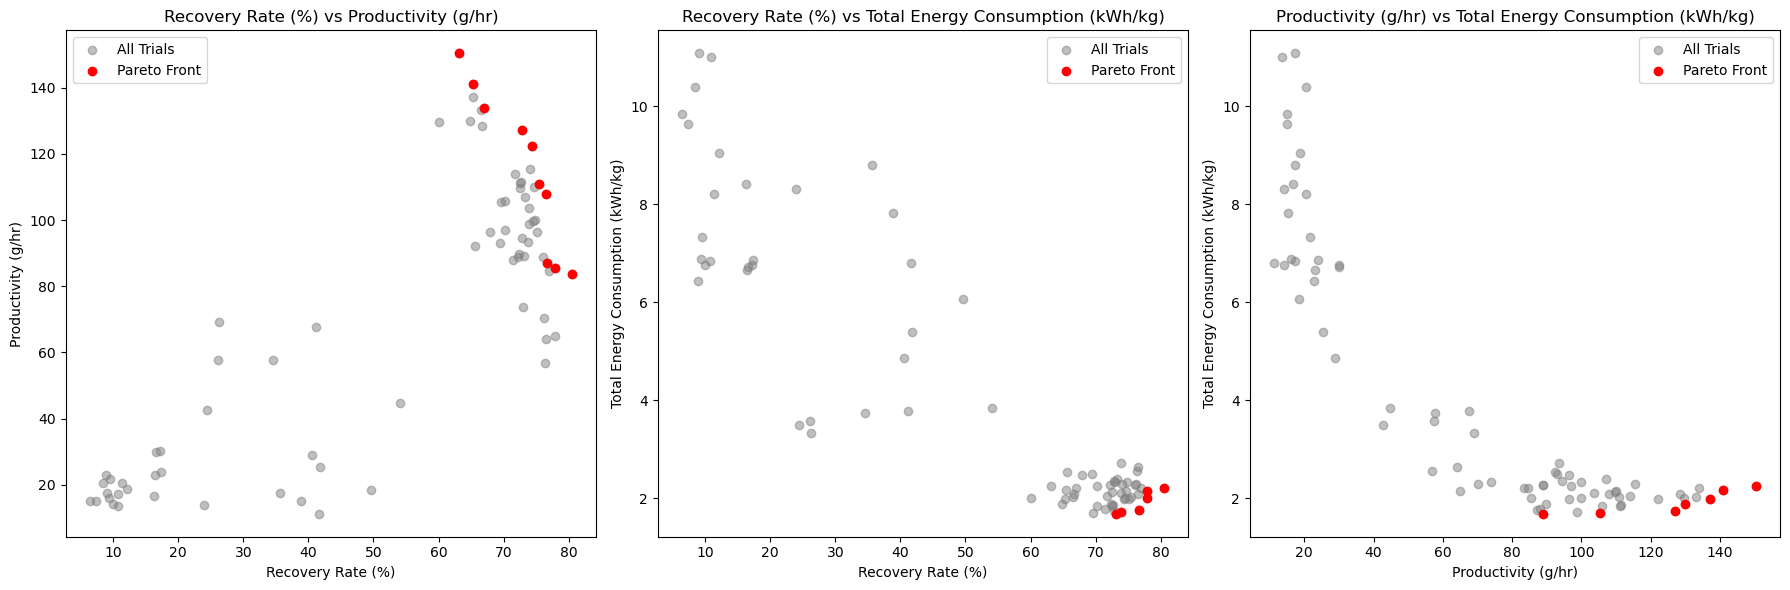

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import optuna

# Optuna DB에서 study 불러오기
db_url = 'sqlite:///bmed_2stage_countercurrent_optimizer.db'
study_name = 'bmed_2stage_countercurrent_optimization_LA productivity'
try:
    study = optuna.load_study(study_name=study_name, storage=db_url)
except Exception as e:
    raise RuntimeError(f"Optuna study를 DB에서 불러올 수 없습니다: {e}")

# optuna study에서 trials의 결과를 추출
trials = [t for t in study.trials if t.values is not None]

# 각 목적함수 값 추출 (정규화된 값)
rrs_norm = [t.values[0] for t in trials]   # Recovery Rate (정규화)
fms_norm = [t.values[1] for t in trials]   # Productivity (정규화)
tecs_norm = [t.values[2] for t in trials]  # Total Energy Consumption (정규화)

# 원래 값으로 복원
rrs = [v * 100 for v in rrs_norm]                # Recovery Rate (%)
fms = [v * 324.36 for v in fms_norm]             # Productivity (g/hr)
tecs = [v * 10 for v in tecs_norm]               # Total Energy Consumption (kWh/kg)

# 에너지 소비량 50을 넘는 trial은 제거 (비정상 데이터 제거)
filtered = [(rr, fm, tec) for rr, fm, tec in zip(rrs, fms, tecs) if tec <= 50]
if filtered:
    rrs, fms, tecs = zip(*filtered)
    rrs = list(rrs)
    fms = list(fms)
    tecs = list(tecs)
else:
    rrs, fms, tecs = [], [], []

# 2D 파레토 프론트 계산 함수 (maximize, minimize 옵션 지원)
def is_pareto_efficient_2d(costs, maximize=[True, True]):
    costs = np.array(costs)
    for i, max_ in enumerate(maximize):
        if max_:
            costs[:, i] = -costs[:, i]
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return is_efficient

# 2개 목적함수 조합별로 파레토 프론트 시각화 (원래 값 사용)
pairs = [
    (rrs, fms, 'Recovery Rate (%)', 'Productivity (g/hr)', [True, True]),
    (rrs, tecs, 'Recovery Rate (%)', 'Total Energy Consumption (kWh/kg)', [True, False]),
    (fms, tecs, 'Productivity (g/hr)', 'Total Energy Consumption (kWh/kg)', [True, False])
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (x, y, xlabel, ylabel, maximize) in enumerate(pairs):
    if len(x) == 0 or len(y) == 0:
        axes[idx].set_title('No valid data')
        continue
    costs_2d = np.stack([x, y], axis=1)
    pareto_mask_2d = is_pareto_efficient_2d(costs_2d, maximize=maximize)
    ax = axes[idx]
    ax.scatter(x, y, c='gray', alpha=0.5, label='All Trials')
    ax.scatter(np.array(x)[pareto_mask_2d], np.array(y)[pareto_mask_2d], c='red', label='Pareto Front')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f'{xlabel} vs {ylabel}')
    ax.legend()

plt.tight_layout()
plt.show()


In [36]:
# 파레토 프론트 기준 출력 (Objective 3개 기준)
print("Pareto front 기준:")
print(" - Recovery Rate: 최대화")
print(" - Productivity: 최대화")
print(" - Total Energy Consumption: 최소화")

import pandas as pd
import numpy as np

# 3D 파레토 프론트 계산 함수 (maximize, minimize 옵션 지원)
def is_pareto_efficient(costs, maximize=[True, True, False]):
    """
    costs: shape (N, 3)
    maximize: 각 목적함수별로 최대화(True)/최소화(False) 여부
    """
    costs = np.array(costs)
    for i, max_ in enumerate(maximize):
        if max_:
            costs[:, i] = -costs[:, i]
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return is_efficient

try:
    # study 또는 trials가 정의되어 있는지 확인
    if 'study' in globals():
        trials = study.trials
    elif 'trials' in globals():
        trials = trials
    else:
        raise NameError("Optuna study/trials 변수가 정의되어 있지 않습니다.")

    # 각 trial의 파라미터 dict 추출
    all_params = [t.params for t in trials]

    # 목적함수 값 배열 생성
    rrs_arr = np.array(rrs)
    fms_arr = np.array(fms)
    tecs_arr = np.array(tecs)
    costs_3d = np.stack([rrs_arr, fms_arr, tecs_arr], axis=1)

    # 3D 파레토 마스크 계산
    pareto_mask = is_pareto_efficient(costs_3d, maximize=[True, True, False])

    # 파레토 trial의 파라미터만 추출
    pareto_params = [all_params[i] for i, is_p in enumerate(pareto_mask) if is_p]
    df_params = pd.DataFrame(pareto_params)
except Exception as e:
    print("trial의 파라미터 정보를 추출할 수 없습니다. 파라미터 정보 없이 결과만 저장합니다.")
    print("에러 메시지:", e)
    df_params = pd.DataFrame()
    # 파레토 마스크도 예외 상황에 대비해 생성
    try:
        rrs_arr = np.array(rrs)
        fms_arr = np.array(fms)
        tecs_arr = np.array(tecs)
        costs_3d = np.stack([rrs_arr, fms_arr, tecs_arr], axis=1)
        pareto_mask = is_pareto_efficient(costs_3d, maximize=[True, True, False])
    except Exception as e2:
        print("Pareto mask 계산도 실패:", e2)
        pareto_mask = np.array([False]*len(rrs))

pareto_results = {
    'Recovery Rate (%)': np.array(rrs)[pareto_mask],
    'Productivity (g/hr)': np.array(fms)[pareto_mask],
    'Total Energy Consumption (kWh/kg)': np.array(tecs)[pareto_mask]
}
df_results = pd.DataFrame(pareto_results)

if not df_params.empty:
    df_pareto = pd.concat([df_params.reset_index(drop=True), df_results.reset_index(drop=True)], axis=1)
else:
    df_pareto = df_results

print("\nPareto front에 해당하는 trial의 조건 및 결과:")
print(df_pareto)

df_pareto.to_csv("pareto_front_trials.csv", index=False)


Pareto front 기준:
 - Recovery Rate: 최대화
 - Productivity: 최대화
 - Total Energy Consumption: 최소화

Pareto front에 해당하는 trial의 조건 및 결과:
    Stage 1 Voltage  Stage 2 Voltage  Stage 1 E Conc  Stage 2 E Conc  \
0              17.0             17.0             0.7             0.9   
1              13.0             16.0             1.0             0.5   
2              22.0             18.0             0.9             0.9   
3              26.0             19.0             0.9             0.9   
4              18.0             14.0             0.9             0.8   
5              15.0             16.0             1.0             0.8   
6              22.0             19.0             0.9             0.9   
7              16.0             14.0             0.9             0.8   
8              15.0             13.0             0.9             0.7   
9              17.0             15.0             1.0             0.8   
10             17.0             15.0             1.0             0.7   
11     

/tmp/ipykernel_47051/3829664050.py:23: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_47051/3829664050.py:23: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_47051/3829664050.py:23: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_47051/3829664050.py:23: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_47051/3829664050.py:23: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_47051/3829664050.py:23: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_47051/3829664050.py:23: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.ti

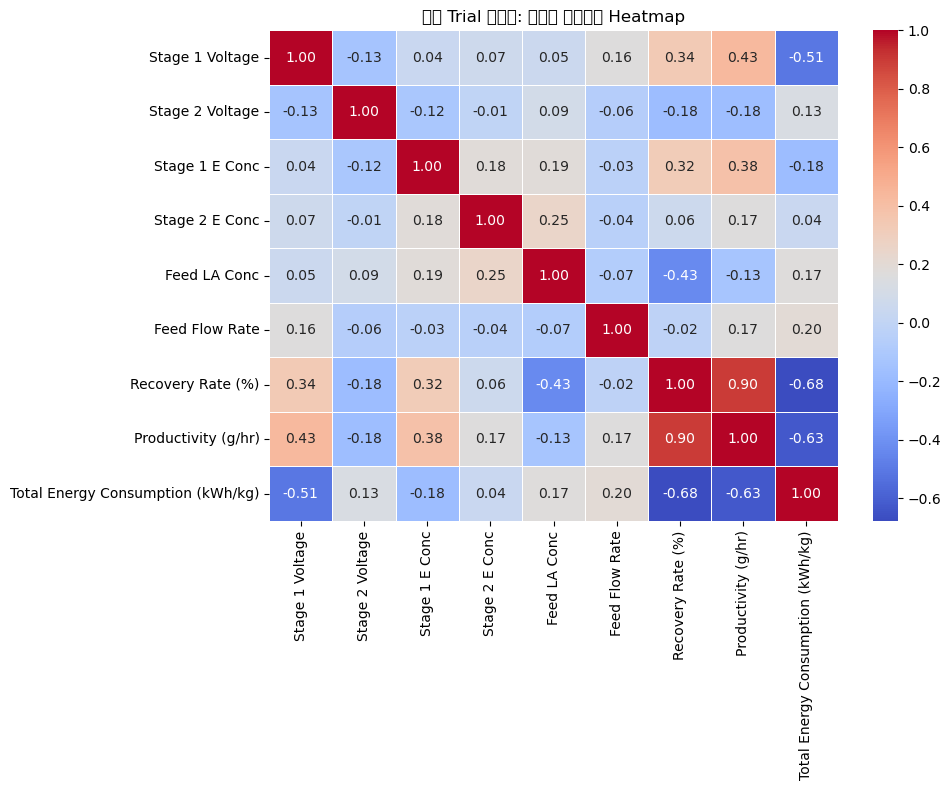

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# 전체 데이터에서 변수별 상관관계 분석
try:
    # all_params와 rrs, fms, tecs가 모두 정의되어 있다고 가정
    df_all_params = pd.DataFrame(all_params)
    all_results = {
        'Recovery Rate (%)': np.array(rrs),
        'Productivity (g/hr)': np.array(fms),
        'Total Energy Consumption (kWh/kg)': np.array(tecs)
    }
    df_all = pd.concat([df_all_params.reset_index(drop=True), pd.DataFrame(all_results).reset_index(drop=True)], axis=1)
except Exception as e:
    print("전체 trial 데이터프레임 생성에 실패했습니다:", e)
    df_all = pd.DataFrame()

corr = df_all.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("전체 Trial 데이터: 변수별 상관관계 Heatmap")
plt.tight_layout()
plt.show()
